In [154]:
import pandas as pd
import random
import math
import haversine
import matplotlib.pyplot as plt
import matplotlib
from numpy import inf
from heapq import heapify, heappop, heappush

In [109]:
def filter_data():
    city_df = pd.read_csv('data/전국공공시설개방정보표준데이터.csv', encoding='cp949')
    city_df = city_df[['관리기관명','개방시설명','개방장소명','위도','경도']]
    city_df = city_df[city_df['관리기관명'].str.contains('서울특별시')]
    extra_df = city_df[city_df['개방시설명'].str.contains('주민센터')]
    extra_df = extra_df[~extra_df['개방장소명'].str.contains('주민센터')]
    extra_df['개방장소명'] = extra_df['개방시설명'].str.split('주민센터').str[0].str.strip()
    extra_df['개방장소명'] = extra_df['개방장소명'].str.split('구 ').str[-1]
    extra_df = extra_df.drop('개방시설명',axis=1).drop_duplicates()
    city_df = city_df.drop(['개방시설명'], axis=1)
    city_df = city_df.dropna()
    city_df = city_df[city_df['개방장소명'].str.contains('주민센터')]
    city_df['개방장소명'] = city_df['개방장소명'].str.split('주민센터').str[0].str.strip()
    city_df['개방장소명'] = city_df['개방장소명'].str.split('구 ').str[-1]
    loc_df = pd.concat([city_df, extra_df])
    loc_df['관리기관명'] = loc_df['관리기관명'].str.split().str[1]
    loc_df['관리기관명'] = loc_df['관리기관명'].str.replace('구청','구')
    loc_df = loc_df.drop_duplicates(subset=['관리기관명', '개방장소명'])
    loc_df['동'] = loc_df['관리기관명'] + ' ' + loc_df['개방장소명']
    loc_dict = loc_df.set_index('동')[['경도','위도']].apply(tuple, axis=1).to_dict()
    return loc_dict
loc_dict = filter_data()
loc_dict

{'노원구 중계4동': (127.077958, 37.658728),
 '노원구 상계1동': (127.054976, 37.679929843),
 '광진구 자양4동': (127.0662584, 37.53409779),
 '광진구 화양동': (127.0713179, 37.54653711),
 '광진구 군자동': (127.075486, 37.555495),
 '도봉구 쌍문2동': (127.0387508, 37.6580211),
 '도봉구 쌍문4동': (127.0283688, 37.6564188),
 '도봉구 쌍문3동': (127.0279086, 37.6489437),
 '도봉구 쌍문1동': (127.0260364, 37.6479992),
 '광진구 광장동': (127.1030098, 37.54688276),
 '광진구 자양1동': (127.0823949, 37.53449795),
 '광진구 자양2동': (127.0843875, 37.52879933),
 '광진구 자양3동': (127.0729024, 37.53383394),
 '광진구 중곡1동': (127.0800521, 37.56066762),
 '광진구 중곡2동': (127.0814751, 37.56015047),
 '광진구 중곡3동': (127.0801381, 37.56880689),
 '광진구 중곡4동': (127.0894329, 37.55909865),
 '광진구 능동': (127.0805521, 37.5537606),
 '광진구 구의1동': (127.0856773, 37.54241324),
 '광진구 구의2동': (127.0899239, 37.54724133),
 '광진구 구의3동': (127.0919847, 37.53799342),
 '도봉구 방학3동': (127.0279921, 37.6591413),
 '도봉구 방학1동': (127.0406367, 37.6641869),
 '도봉구 방학2동': (127.0350425, 37.668177),
 '도봉구 창1동': (127.0440451, 37.6485286

In [113]:
# Get random example
random.seed(100)
keys_list = list(loc_dict.keys())
towns = random.sample(keys_list, 10)
keys_list = [i for i in keys_list if i not in towns]
hospital = random.sample(keys_list, 2)
keys_list = [i for i in keys_list if i not in hospital]
ambulance = random.sample(keys_list, 1)
towns, hospital, ambulance

(['노원구 공릉1동',
  '서초구 방배2동',
  '서초구 방배1동',
  '강북구 수유2동',
  '강동구 둔촌2동',
  '관악구 청림동',
  '중랑구 묵1동',
  '성동구 사근동',
  '구로구 고척2동',
  '중랑구 신내1동'],
 ['중구 황학동', '송파구 잠실4동'],
 ['성동구 응봉동'])

In [137]:
def make_paths(loc_dict, towns, hospital, ambulance):
    city = towns + hospital + ambulance
    connections = []
    graph_dict = {}
    for node in city:
        distance = []
        x1, y1 = loc_dict[node]
        graph_dict[node] = loc_dict[node]
        if node in towns:
            connect = random.randint(1,3)
        else:
            connect = 4
        counted = [i[1] for i in connections if node == i[1]]
        connect -= len(counted)
        for test in city:
            if node == test:
                continue
            if connect == 0:
                break
            x2, y2 = loc_dict[test]
            dist = haversine.distance((x1,y1),(x2,y2))
            distance.append((test, dist))
        con_city = sorted(distance, key=lambda x:x[1])[:connect+1]
        connections += [(i[1], node, i[0]) for i in con_city]
    return connections, graph_dict

edges,graph_dict = make_paths(loc_dict, towns, hospital, ambulance)
edges, graph_dict

([(0.9794882745330652, '노원구 공릉1동', '중랑구 묵1동'),
  (3.1316406113826107, '노원구 공릉1동', '중랑구 신내1동'),
  (5.2679915636217185, '노원구 공릉1동', '성동구 사근동'),
  (1.024426647939939, '서초구 방배2동', '서초구 방배1동'),
  (3.1016787600858513, '서초구 방배2동', '관악구 청림동'),
  (7.090526679432324, '서초구 방배2동', '중구 황학동'),
  (7.239881871137728, '서초구 방배2동', '성동구 응봉동'),
  (1.024426647939939, '서초구 방배1동', '서초구 방배2동'),
  (4.0304326582453225, '서초구 방배1동', '관악구 청림동'),
  (6.364596384339001, '서초구 방배1동', '성동구 응봉동'),
  (5.172734915454525, '강북구 수유2동', '중구 황학동'),
  (6.136938121302798, '강북구 수유2동', '노원구 공릉1동'),
  (6.290450788449695, '강북구 수유2동', '성동구 사근동'),
  (3.417168498763811, '강동구 둔촌2동', '송파구 잠실4동'),
  (6.779572221261132, '강동구 둔촌2동', '중랑구 신내1동'),
  (8.830580626071628, '강동구 둔촌2동', '중랑구 묵1동'),
  (3.1016787600858513, '관악구 청림동', '서초구 방배2동'),
  (4.0304326582453225, '관악구 청림동', '서초구 방배1동'),
  (0.9794882745330652, '중랑구 묵1동', '노원구 공릉1동'),
  (2.380522606064914, '중랑구 묵1동', '중랑구 신내1동'),
  (1.4870596754203047, '성동구 사근동', '성동구 응봉동'),
  (2.75352718395044, '

Text(0, 0.5, 'latitude')

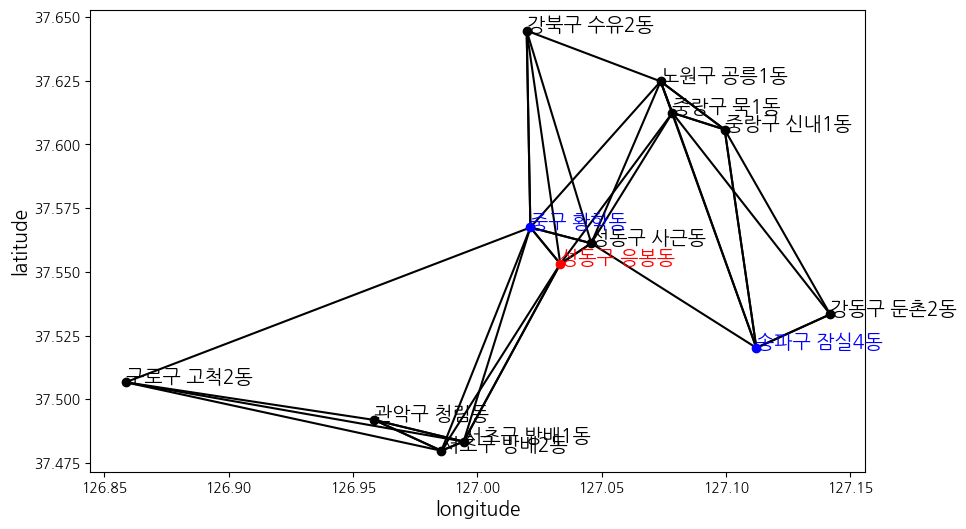

In [142]:
# make a map with cities
path = r"C:\Users\pyslu\Downloads\nanum-gothic\NanumGothic.ttf"
font_name = matplotlib.font_manager.FontProperties(fname=path).get_name()
plt.rcParams.update({'font.family':font_name})
fig, ax = plt.subplots(figsize=(10, 6))
for city, (lon, lat) in graph_dict.items():
    if city in hospital:
        ax.scatter(lon, lat, color="blue", zorder=4)                      #complete
        ax.text(lon, lat, city, fontsize=14, zorder=3, color="blue")
    elif city in ambulance:
        ax.scatter(lon, lat, color="red", zorder=4)                      #complete
        ax.text(lon, lat, city, fontsize=14, zorder=3, color="red")
    else:
        ax.scatter(lon, lat, color="black", zorder=3)                      #complete
        ax.text(lon, lat, city, fontsize=14, zorder=3, color="black")

for w, c1, c2 in edges:
    x1, y1 = graph_dict[c1]                                    #complete
    x2, y2 = graph_dict[c2]                                      #complete
    plt.plot([x1,x2],[y1,y2], color='black', zorder=1)

ax.set_xlabel('longitude', fontsize=14)
ax.set_ylabel('latitude', fontsize=14)

In [156]:
def edges_to_adj_list(edges):
    """
    Transforms a set of edges in an adjacency list (represented as a dictiornary)
    For UNDIRECTED graphs, i.e. if v2 in adj_list[v1], then v1 in adj_list[v2]
    INPUT:
        - edges : a set or list of edges
    OUTPUT:
        - adj_list: a dictionary with the vertices as keys, each with
                a set of adjacent vertices.
    """
    adj_list = {}  # store in dictionary
    for w, v1, v2 in edges:
        t = math.ceil(w/70*60)
        add_dict = {'TravelTime': t, 'TrafficTime': round(t*0.1,2)}
        if v1 in adj_list:  # edge already in it
            adj_list[v1][v2] = add_dict
        else:
            adj_list[v1] = {v2:add_dict}
        if v2 in adj_list:  # edge already in it
            adj_list[v2][v1] = add_dict
        else:
            adj_list[v2] = {v1:add_dict}
    return adj_list

edges_to_adj_list(edges)

{'노원구 공릉1동': {'중랑구 묵1동': {'TravelTime': 1, 'TrafficTime': 0.1},
  '중랑구 신내1동': {'TravelTime': 3, 'TrafficTime': 0.3},
  '성동구 사근동': {'TravelTime': 5, 'TrafficTime': 0.5},
  '강북구 수유2동': {'TravelTime': 6, 'TrafficTime': 0.6},
  '중구 황학동': {'TravelTime': 6, 'TrafficTime': 0.6},
  '송파구 잠실4동': {'TravelTime': 8, 'TrafficTime': 0.8}},
 '중랑구 묵1동': {'노원구 공릉1동': {'TravelTime': 1, 'TrafficTime': 0.1},
  '강동구 둔촌2동': {'TravelTime': 8, 'TrafficTime': 0.8},
  '중랑구 신내1동': {'TravelTime': 3, 'TrafficTime': 0.3},
  '성동구 사근동': {'TravelTime': 5, 'TrafficTime': 0.5},
  '송파구 잠실4동': {'TravelTime': 7, 'TrafficTime': 0.7},
  '성동구 응봉동': {'TravelTime': 6, 'TrafficTime': 0.6}},
 '중랑구 신내1동': {'노원구 공릉1동': {'TravelTime': 3, 'TrafficTime': 0.3},
  '강동구 둔촌2동': {'TravelTime': 6, 'TrafficTime': 0.6},
  '중랑구 묵1동': {'TravelTime': 3, 'TrafficTime': 0.3},
  '송파구 잠실4동': {'TravelTime': 6, 'TrafficTime': 0.6}},
 '성동구 사근동': {'노원구 공릉1동': {'TravelTime': 5, 'TrafficTime': 0.5},
  '강북구 수유2동': {'TravelTime': 6, 'TrafficTime': 0.6},
  '성

In [139]:
def reconstruct_path(previous, source, sink):
    """
    Reconstruct the path from the output of the Dijkstra algorithm.
    Inputs:
            - previous : a dict with the previous node in the path
            - source : the source node
            - sink : the sink node
    Ouput:
            - the shortest path from source to sink
    """
    if sink not in previous:
        return []
    v = sink
    path = [v]
    while v is not source:
        v = previous[v]                           #complete
        path = [v] + path                          #complete
    return path

In [143]:
# STMO-P7
# heuristic: haversine (lat&lon)
traffic_factor = {'7-9': 0.8, '11-13': 0.5, '17-19': 0.8, '19-24': 0.5, '24-7': 0.1}

def a_star(graph, source, sink, heuristic, traffic_factor):
    """
    Implementation of the A* shortest path algorithm
    Inputs:
        - graph : dict representing the graph
        - source : the source node
        - sink : the sink node (optional)
        - heuristic : a function with the heuristic for the shortest path between two nodes
    Ouput:
        - distance : dict with the distances of the nodes to the source
        - came_from : dict with for each node the previous node in the shortest
                    path from the source
    """
    # keep tentative distance source to vertex
    # initialize with infinity, except for the source
    distance = {v : inf for v in graph.keys()}
    distance[source] = 0
    # keep previous node in path for backtracking
    previous = {}
    # vertices_to_check is a heap using the estimated distance
    # of a given node to a source as the priority
    vertices_to_check = [(heuristic(source, sink), source)]             #complete
    previous = {}
    N_vertices = 0

#complete below (you can start from the Dijkstra algorithm)    
    while vertices_to_check:
        heuristic_dis, current = heappop(vertices_to_check)
        if current == sink:
            return reconstruct_path(previous, source, sink), distance[sink]
        for dist_current_neighbor, neighbor in graph[current]:
            new_dist_from_source = distance[current] + dist_current_neighbor
            if new_dist_from_source < distance[neighbor]:
                min_dist_neighbor_source = distance[neighbor] + heuristic(neighbor, sink)
                heappush(vertices_to_check, min_dist_neighbor_source, neighbor)
                previous[neighbor] = current

In [55]:
# Example
graph = {
    'A': {'B': {'travelTime': 10, 'trafficTime': 2}, 'C': {'travelTime': 5, 'trafficTime': 1}},
    'B': {'C': {'travelTime': 8, 'trafficTime': 3}},
    'C': {'D': {'travelTime': 6, 'trafficTime': 2}},
    'D': {'E': {'travelTime': 4, 'trafficTime': 1}},
    'E': {}
}

def AStarWithTraffic(graph, start, goal, traffic_factor):
    openSet = []
    openSet.append((0, start))
    cameFrom = {}
    gScore = {}
    gScore[start] = 0
    fScore = {}
    fScore[start] = heuristic(start, goal)

    while openSet:
        current = min(openSet, key=lambda x: fScore[x[1]])
        openSet.remove(current)

        if current[1] == goal:
            return reconstructPath(cameFrom, current[1])

        for neighbor in graph.neighbors(current[1]):
            edge = graph.get_edge(current[1], neighbor)
            travelTime = edge.travelTime
            trafficTime = edge.trafficTime
            # Assume trafficTime is the additional time due to traffic conditions

            # Calculate the tentative gScore and fScore for the neighbor
            tentative_gScore = gScore[current[1]] + (travelTime + traffic_factor * trafficTime)
            tentative_fScore = tentative_gScore + heuristic(neighbor, goal)

            if neighbor not in gScore or tentative_gScore < gScore[neighbor]:
                cameFrom[neighbor] = current[1]
                gScore[neighbor] = tentative_gScore
                fScore[neighbor] = tentative_fScore

                if neighbor not in [node[1] for node in openSet]:
                    openSet.append((tentative_fScore, neighbor))

    return None  # No path found


'''In this updated version, we assume that the edge object has a new attribute trafficTime, which represents the additional time required due to traffic conditions along that edge. The traffic_factor is a parameter that you can adjust to control the influence of traffic on the estimated travel time.

The tentative gScore is calculated by adding the base travel time (travelTime) and the traffic-adjusted time (traffic_factor * trafficTime) to the previous gScore. This ensures that the algorithm considers the traffic conditions when determining the shortest path.

Please note that the exact implementation may depend on the specific structure of your graph and the representation of edge data. Adjust the code accordingly based on your graph implementation.
'''

'In this updated version, we assume that the edge object has a new attribute trafficTime, which represents the additional time required due to traffic conditions along that edge. The traffic_factor is a parameter that you can adjust to control the influence of traffic on the estimated travel time.\n\nThe tentative gScore is calculated by adding the base travel time (travelTime) and the traffic-adjusted time (traffic_factor * trafficTime) to the previous gScore. This ensures that the algorithm considers the traffic conditions when determining the shortest path.\n\nPlease note that the exact implementation may depend on the specific structure of your graph and the representation of edge data. Adjust the code accordingly based on your graph implementation.\n'